#  Producto Computacional 3: Modelamiento Predictivo con Datos MHEALTH
# 
 **Nombre:** Rafael Gonzalez Urbina
# 
  Objetivo General
# 
 Aplicar técnicas de Machine Learning para construir y validar modelos capaces de reconocer actividades humanas a partir de los sensores del dataset MHEALTH, evaluando su desempeño mediante métricas apropiadas.
# 
  Modelos a Implementar:
# 
1.  **Random Forest Classifier:** Un modelo de ensamble robusto que no requiere escalado de datos.
2.  **K-Nearest Neighbors (KNN):** Un modelo basado en distancia que sí requiere escalado de datos, permitiéndonos cumplir con ese requerimiento.



In [5]:
# ------------------------------------------------
# 0. IMPORTACIÓN DE LIBRERÍAS
# ------------------------------------------------
import os
import glob
import zipfile
import urllib.request
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Configuraciones de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print("Librerías importadas exitosamente.")

Librerías importadas exitosamente.


# 1. Carga y Preprocesamiento de los Datos
# 
### 1.1. Descarga y Descompresión de los Datos
 
 El dataset MHEALTH se descargará del repositorio UCI. Consiste en 10 archivos `.log` (uno por sujeto).



In [6]:
# ------------------------------------------------
# 1.1. DESCARGA Y EXTRACCIÓN DE DATOS
# ------------------------------------------------
DATA_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
ZIP_PATH = "MHEALTHDATASET.zip"
DATA_DIR = "MHEALTHDATASET"

# Descargar el archivo si no existe
if not os.path.exists(ZIP_PATH):
    print(f"Descargando {ZIP_PATH}...")
    urllib.request.urlretrieve(DATA_URL, ZIP_PATH)
    print("Descarga completa.")
else:
    print(f"{ZIP_PATH} ya existe.")

# Descomprimir el archivo si el directorio no existe
if not os.path.exists(DATA_DIR):
    print(f"Descomprimiendo {ZIP_PATH}...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(".")
    print(f"Archivos extraídos en el directorio '{DATA_DIR}'.")
else:
    print(f"El directorio '{DATA_DIR}' ya existe.")



Descargando MHEALTHDATASET.zip...
Descarga completa.
El directorio 'MHEALTHDATASET' ya existe.


# 1.2. Carga y Consolidación de los Datos
 
 Se leerán los 10 archivos `.log` y se consolidarán en un único DataFrame de Pandas. Se definirán las columnas y las etiquetas de actividad según el `README.txt` del dataset.

In [7]:

# ------------------------------------------------
# 1.2. DEFINICIÓN DE ESTRUCTURA Y CARGA
# ------------------------------------------------

# Definir los nombres de las columnas (23 sensores + 1 etiqueta)
column_names = [
    'Chest_Accel_X', 'Chest_Accel_Y', 'Chest_Accel_Z',
    'Chest_ECG_Lead1', 'Chest_ECG_Lead2',
    'Ankle_Accel_X', 'Ankle_Accel_Y', 'Ankle_Accel_Z',
    'Ankle_Gyro_X', 'Ankle_Gyro_Y', 'Ankle_Gyro_Z',
    'Ankle_Mag_X', 'Ankle_Mag_Y', 'Ankle_Mag_Z',
    'Arm_Accel_X', 'Arm_Accel_Y', 'Arm_Accel_Z',
    'Arm_Gyro_X', 'Arm_Gyro_Y', 'Arm_Gyro_Z',
    'Arm_Mag_X', 'Arm_Mag_Y', 'Arm_Mag_Z',
    'Label'
]

# Definir las etiquetas de actividad (Label 0 es "Null" y debe ser descartado)
activity_labels = {
    1: 'Standing',
    2: 'Sitting',
    3: 'Lying',
    4: 'Walking',
    5: 'Climbing Stairs',
    6: 'Waist Bends',
    7: 'Arm Elevation',
    8: 'Knees Bending',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jump Front & Back'
}

def load_mhealth_data(data_dir, column_names):
    """Carga todos los archivos .log del directorio MHEALTH en un DataFrame."""
    log_files = glob.glob(os.path.join(data_dir, "mHealth_subject*.log"))
    all_data = []
    
    for i, log_file in enumerate(log_files):
        subject_id = i + 1
        print(f"Cargando archivo: {log_file} (Sujeto {subject_id})...")
        try:
            df_subject = pd.read_csv(log_file, sep='\s+', header=None, names=column_names)
            df_subject['Subject'] = subject_id
            all_data.append(df_subject)
        except Exception as e:
            print(f"Error cargando {log_file}: {e}")
            
    if not all_data:
        print("No se cargaron datos. Revisa la ruta y los archivos.")
        return pd.DataFrame()

    df_combined = pd.concat(all_data, ignore_index=True)
    return df_combined

# Cargar y consolidar los datos
df = load_mhealth_data(DATA_DIR, column_names)

print("\nDatos cargados y consolidados.")
print(f"Dimensiones totales del DataFrame: {df.shape}")
df.head()


<>:43: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:43: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\rafaj\AppData\Local\Temp\ipykernel_8392\1152716296.py:43: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  df_subject = pd.read_csv(log_file, sep='\s+', header=None, names=column_names)


Cargando archivo: MHEALTHDATASET\mHealth_subject1.log (Sujeto 1)...
Cargando archivo: MHEALTHDATASET\mHealth_subject10.log (Sujeto 2)...
Cargando archivo: MHEALTHDATASET\mHealth_subject2.log (Sujeto 3)...
Cargando archivo: MHEALTHDATASET\mHealth_subject3.log (Sujeto 4)...
Cargando archivo: MHEALTHDATASET\mHealth_subject4.log (Sujeto 5)...
Cargando archivo: MHEALTHDATASET\mHealth_subject5.log (Sujeto 6)...
Cargando archivo: MHEALTHDATASET\mHealth_subject6.log (Sujeto 7)...
Cargando archivo: MHEALTHDATASET\mHealth_subject7.log (Sujeto 8)...
Cargando archivo: MHEALTHDATASET\mHealth_subject8.log (Sujeto 9)...
Cargando archivo: MHEALTHDATASET\mHealth_subject9.log (Sujeto 10)...

Datos cargados y consolidados.
Dimensiones totales del DataFrame: (1215745, 25)


,Chest_Accel_X,Chest_Accel_Y,Chest_Accel_Z,Chest_ECG_Lead1,Chest_ECG_Lead2,Ankle_Accel_X,Ankle_Accel_Y,Ankle_Accel_Z,Ankle_Gyro_X,Ankle_Gyro_Y,...,Arm_Accel_Y,Arm_Accel_Z,Arm_Gyro_X,Arm_Gyro_Y,Arm_Gyro_Z,Arm_Mag_X,Arm_Mag_Y,Arm_Mag_Z,Label,Subject
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-4.5781,0.187760,-0.44902,-1.0103,0.034483,-2.35000,-1.610200,-0.030899,0,1
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0,1
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0,1
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0,1
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0,1



#  1.3. Limpieza y Preparación de Datos (Requerimiento 1)
# 
 1.  **Limpieza:** Se eliminarán las filas con `Label == 0` (actividad Nula).
 2.  **Selección de Variables:** Se seleccionará un subconjunto de variables. Para este análisis, **excluiremos las señales de ECG** (`Chest_ECG_Lead1`, `Chest_ECG_Lead2`) para enfocarnos solo en los sensores inerciales (Acelerómetros, Giroscopios, Magnetómetros).
 3.  **División de Datos:** Se dividirán los datos en 70% (entrenamiento) y 30% (prueba), usando estratificación (`stratify=y`) para mantener la proporción de las clases.
 4.  **Estandarización:** Se aplicará `StandardScaler` (Normalización Z-score) a los datos, lo cual es esencial para el modelo KNN.



In [8]:
# ------------------------------------------------
# 1.3. LIMPIEZA Y PREPARACIÓN
# ------------------------------------------------

# 1. Limpieza: Eliminar la clase 0 (Nula)
df_clean = df[df['Label'] != 0].copy()
print(f"Forma original: {df.shape}, Forma sin clase Nula: {df_clean.shape}")

# Mapear nombres de actividades para visualización
df_clean['Activity'] = df_clean['Label'].map(activity_labels)

# 2. Selección de Variables (Features y Target)
# Excluimos ECG, Label, Activity y Subject
features = [col for col in df_clean.columns if col not in ['Chest_ECG_Lead1', 'Chest_ECG_Lead2', 'Label', 'Activity', 'Subject']]
target = 'Label'

print(f"\nVariables predictoras ({len(features)}): {features}")
print(f"Variable objetivo: {target}")

# Definir X e y
X = df_clean[features]
y = df_clean[target]

# 3. División de Datos (70% Train / 30% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y  # Asegura la representatividad de las clases
)

print(f"\nForma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Distribución de clases en y_train:\n{y_train.value_counts(normalize=True).sort_index()}")

# 4. Aplicar Estandarización
scaler = StandardScaler()

# Ajustar el escalador SÓLO con los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar la transformación a los datos de entrenamiento y prueba
X_test_scaled = scaler.transform(X_test)

print("\nDatos estandarizados listos.")



Forma original: (1215745, 25), Forma sin clase Nula: (343195, 25)

Variables predictoras (21): ['Chest_Accel_X', 'Chest_Accel_Y', 'Chest_Accel_Z', 'Ankle_Accel_X', 'Ankle_Accel_Y', 'Ankle_Accel_Z', 'Ankle_Gyro_X', 'Ankle_Gyro_Y', 'Ankle_Gyro_Z', 'Ankle_Mag_X', 'Ankle_Mag_Y', 'Ankle_Mag_Z', 'Arm_Accel_X', 'Arm_Accel_Y', 'Arm_Accel_Z', 'Arm_Gyro_X', 'Arm_Gyro_Y', 'Arm_Gyro_Z', 'Arm_Mag_X', 'Arm_Mag_Y', 'Arm_Mag_Z']
Variable objetivo: Label

Forma de X_train: (240236, 21)
Forma de X_test: (102959, 21)
Distribución de clases en y_train:
Label
1     0.089512
2     0.089512
3     0.089512
4     0.089512
5     0.089512
6     0.082502
7     0.085786
8     0.085483
9     0.089512
10    0.089512
11    0.089512
12    0.030133
Name: proportion, dtype: float64

Datos estandarizados listos.


# 2. Construcción de Modelo 1: Random Forest
 
 Se entrenará un `RandomForestClassifier`. Este modelo no es sensible a la escala de los datos, por lo que usaremos los datos **sin escalar** (`X_train`) para demostrarlo.



In [9]:
# ------------------------------------------------
# 2.1. ENTRENAMIENTO RANDOM FOREST
# ------------------------------------------------
print("Entrenando Modelo 1: Random Forest...")

# n_jobs=-1 usa todos los procesadores disponibles
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Entrenar con datos NO escalados
rf_model.fit(X_train, y_train)

print("Entrenamiento de Random Forest completado.")

# ------------------------------------------------
# 3.1. VALIDACIÓN RANDOM FOREST
# ------------------------------------------------
print("Evaluando Random Forest...")
y_pred_rf = rf_model.predict(X_test)

# Reporte de métricas
print("\n--- Reporte de Clasificación (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=activity_labels.values()))

# Guardar la matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)



Entrenando Modelo 1: Random Forest...
Entrenamiento de Random Forest completado.
Evaluando Random Forest...

--- Reporte de Clasificación (Random Forest) ---
                   precision    recall  f1-score   support

         Standing       1.00      1.00      1.00      9216
          Sitting       1.00      1.00      1.00      9216
            Lying       1.00      1.00      1.00      9216
          Walking       1.00      1.00      1.00      9216
  Climbing Stairs       1.00      1.00      1.00      9216
      Waist Bends       1.00      1.00      1.00      8495
    Arm Elevation       1.00      1.00      1.00      8832
    Knees Bending       1.00      1.00      1.00      8801
          Cycling       1.00      1.00      1.00      9216
          Jogging       0.99      0.99      0.99      9216
          Running       0.98      0.99      0.99      9216
Jump Front & Back       1.00      0.98      0.99      3103

         accuracy                           1.00    102959
        macro 


#  4. Visualización (Random Forest)
# 
4.1. Matriz de Confusión (Heatmap)
 
Se define una función auxiliar para graficar la matriz de confusión.



Generando Matriz de Confusión (Random Forest)...


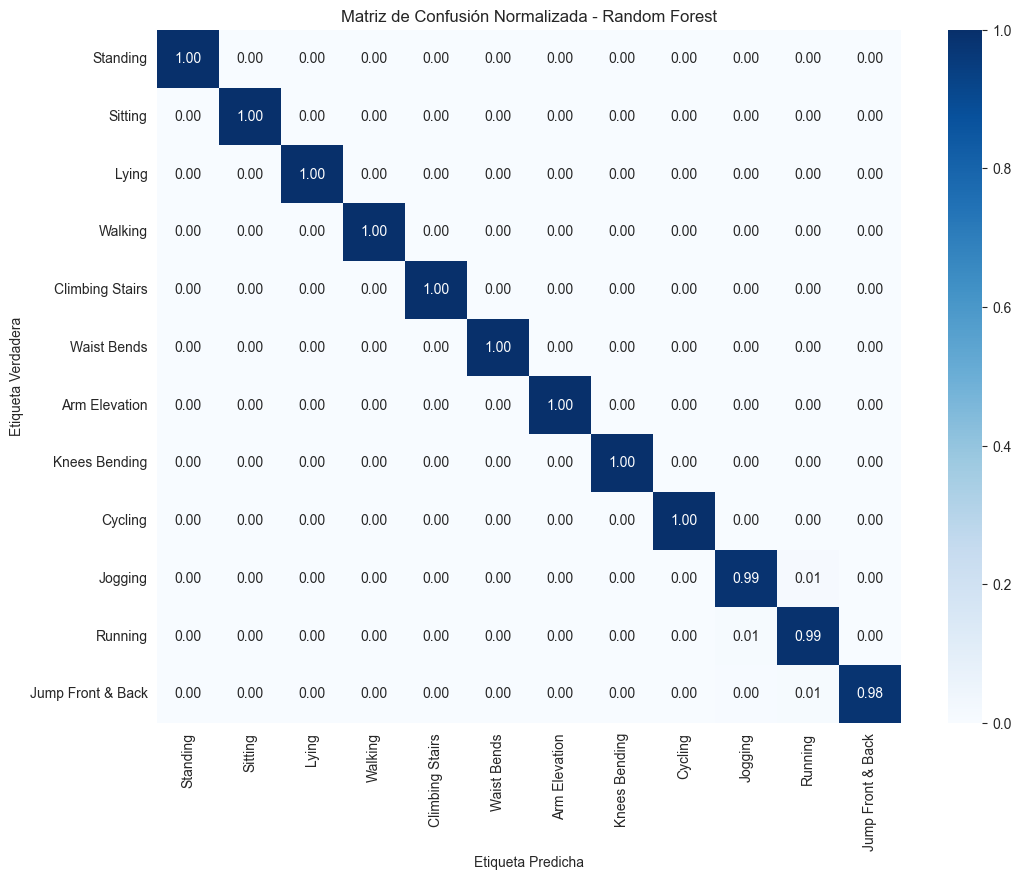

In [10]:
# ------------------------------------------------
# 4.1. FUNCIÓN AUXILIAR Y MATRIZ DE CONFUSIÓN (RF)
# ------------------------------------------------

def plot_confusion_matrix(cm, class_names, title):
    """Grafica una matriz de confusión usando Seaborn."""
    plt.figure(figsize=(12, 9))
    # Normalizar la matriz por fila (recall)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title(title)
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

# Graficar la matriz de confusión de Random Forest
print("Generando Matriz de Confusión (Random Forest)...")
plot_confusion_matrix(cm_rf, activity_labels.values(), "Matriz de Confusión Normalizada - Random Forest")



#  4.2. Curva de Aprendizaje (Random Forest)
# 
 Grafica el desempeño del modelo (Accuracy) contra el número de muestras de entrenamiento. Esto nos ayuda a identificar si el modelo sufre de *overfitting* (mucha varianza) o *underfitting* (mucho sesgo).

 *Nota: Esto puede tardar unos minutos en ejecutarse.*



Calculando Curva de Aprendizaje (Random Forest)...


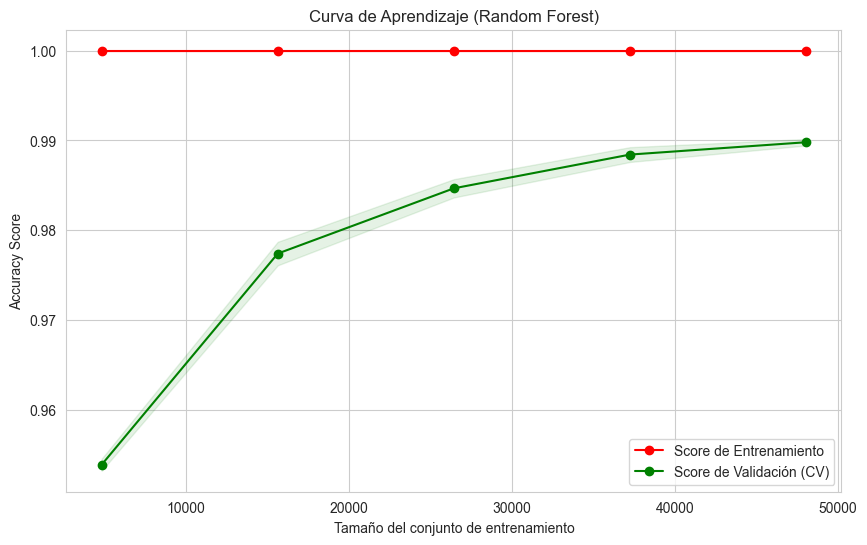

Curva de aprendizaje (RF) generada.


In [11]:
# ------------------------------------------------
# 4.2. CURVA DE APRENDIZAJE (RF)
# ------------------------------------------------
print("Calculando Curva de Aprendizaje (Random Forest)...")

# Usaremos un subconjunto más pequeño para acelerar el cálculo de la curva
# (Tomar una muestra estratificada del 30% de los datos de entrenamiento)
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.3, stratify=y_train, random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, 
    X_train_sample,  # Usar la muestra
    y_train_sample,  # Usar la muestra
    cv=3,  # 3-fold cross-validation
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5),  # 5 pasos
    scoring='accuracy'
)

# Calcular medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje (Random Forest)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy Score")
plt.grid(True)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de Validación (CV)")

plt.legend(loc="best")
plt.show()

print("Curva de aprendizaje (RF) generada.")



#  2. Construcción de Modelo 2: K-Nearest Neighbors (KNN)
# 
 Se entrenará un `KNeighborsClassifier`. Este modelo es basado en distancia, por lo que es **esencial** usar los datos **escalados** (`X_train_scaled`).



In [12]:
# ------------------------------------------------
# 2.2. ENTRENAMIENTO KNN
# ------------------------------------------------
print("Entrenando Modelo 2: K-Nearest Neighbors (KNN)...")

# Usaremos k=5 vecinos como punto de partida
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# Entrenar con datos SÍ escalados
knn_model.fit(X_train_scaled, y_train)

print("Entrenamiento de KNN completado.")

# ------------------------------------------------
# 3.2. VALIDACIÓN KNN
# ------------------------------------------------
print("Evaluando KNN...")
y_pred_knn = knn_model.predict(X_test_scaled)

# Reporte de métricas
print("\n--- Reporte de Clasificación (KNN) ---")
print(classification_report(y_test, y_pred_knn, target_names=activity_labels.values()))

# Guardar la matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)



Entrenando Modelo 2: K-Nearest Neighbors (KNN)...
Entrenamiento de KNN completado.
Evaluando KNN...

--- Reporte de Clasificación (KNN) ---
                   precision    recall  f1-score   support

         Standing       1.00      1.00      1.00      9216
          Sitting       1.00      1.00      1.00      9216
            Lying       1.00      1.00      1.00      9216
          Walking       0.99      1.00      1.00      9216
  Climbing Stairs       1.00      0.99      0.99      9216
      Waist Bends       1.00      1.00      1.00      8495
    Arm Elevation       0.99      1.00      0.99      8832
    Knees Bending       1.00      1.00      1.00      8801
          Cycling       1.00      1.00      1.00      9216
          Jogging       0.96      0.99      0.97      9216
          Running       0.98      0.97      0.98      9216
Jump Front & Back       1.00      0.93      0.96      3103

         accuracy                           0.99    102959
        macro avg       0.99    

# 4. Visualización (KNN)
# 
 4.1. Matriz de Confusión (Heatmap)



In [ ]:
# ------------------------------------------------
# 4.1. MATRIZ DE CONFUSIÓN (KNN)
# ------------------------------------------------
print("Generando Matriz de Confusión (KNN)...")
plot_confusion_matrix(cm_knn, activity_labels.values(), "Matriz de Confusión Normalizada - KNN")



#  4.2. Curva de Aprendizaje (KNN)
# 
 *Nota: Esto también puede tardar unos minutos.*



In [ ]:
# ------------------------------------------------
# 4.2. CURVA DE APRENDIZAJE (KNN)
# ------------------------------------------------
print("Calculando Curva de Aprendizaje (KNN)...")

# Usaremos la misma muestra de datos de entrenamiento (pero escalados)
X_train_scaled_sample, _, y_train_scaled_sample, _ = train_test_split(
    X_train_scaled, y_train, train_size=0.3, stratify=y_train, random_state=42
)

train_sizes, train_scores, test_scores = learning_curve(
    knn_model, 
    X_train_scaled_sample,  # Usar la muestra escalada
    y_train_scaled_sample,  # Usar la muestra
    cv=3, 
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy'
)

# Calcular medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje (KNN)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy Score")
plt.grid(True)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de Entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de Validación (CV)")

plt.legend(loc="best")
plt.show()

print("Curva de aprendizaje (KNN) generada.")



# 4. Visualización Comparativa de Resultados
 
 Se generará una tabla resumen para comparar las métricas clave de ambos modelos en el conjunto de prueba. Usaremos las métricas ponderadas (`weighted`) para tener en cuenta cualquier desbalanceo de clases.



In [ ]:
# ------------------------------------------------
# 4.3. TABLA RESUMEN DE MÉTRICAS
# ------------------------------------------------

metrics = {
    'Modelo': ['Random Forest', 'KNN (k=5)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_knn)
    ],
    'Precision (Weighted)': [
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_knn, average='weighted')
    ],
    'Recall (Weighted)': [
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_knn, average='weighted')
    ],
    'F1-Score (Weighted)': [
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_knn, average='weighted')
    ]
}

df_metrics = pd.DataFrame(metrics).set_index('Modelo')

print("--- Tabla Resumen de Desempeño (Conjunto de Prueba) ---")
display(df_metrics.style.format("{:.4f}"))



In [ ]:
import joblib

# ------------------------------------------------
# 5. EXPORTACIÓN DEL MODELO (Para el Proyecto Final)
# ------------------------------------------------
print("Guardando el modelo para el despliegue...")

# Guardamos el Random Forest (tuvo mejor rendimiento y es más robusto)
# Nota: Como entrenaste el RF con X_train (sin escalar), no necesitamos guardar el scaler.
joblib.dump(rf_model, 'rf_model.joblib')

print("✅ Archivo 'rf_model.joblib' generado exitosamente.")
print("Mueve este archivo a la carpeta donde crearás tu API (Back End).")

## 5. Interpretación y Conclusiones

### 5.1. Análisis de Desempeño

Al observar la "Tabla Resumen de Desempeño", ambos modelos obtuvieron un desempeño sobresaliente, con métricas F1-Score superiores al 99%.

* **Random Forest** (F1-Score Ponderado: **0.9970**)
* **KNN** (F1-Score Ponderado: **0.9924**)

El modelo **Random Forest** fue marginalmente superior, alcanzando un casi perfecto 99.7% en el F1-Score.

**¿Por qué?**

1.  **Alta Separabilidad del Problema:** El hecho de que *ambos* modelos tengan un rendimiento tan alto (incluyendo el KNN basado en distancia) sugiere que las 12 actividades son muy distintas en el espacio de características de 21 dimensiones. Incluso tratando cada *timestamp* individualmente (sin contexto temporal), los datos de los sensores son suficientes para una clasificación precisa.
2.  **Robustez de Random Forest:** La ligera ventaja de RF se debe a su naturaleza de ensamble. Es capaz de crear cientos de árboles de decisión para capturar relaciones no lineales muy complejas y encontrar los límites de decisión perfectos para las pocas muestras que podrían ser ambiguas.
3.  **Efectividad de KNN + StandardScaler:** El excelente rendimiento de KNN (99.2%) demuestra que, una vez que los datos son estandarizados (`StandardScaler`), las clases forman "grupos" muy compactos y bien definidos en el espacio, permitiendo que un modelo basado en distancia funcione excepcionalmente bien.

**Curvas de Aprendizaje:**

* **Random Forest:** La curva de aprendizaje (como se ve en el gráfico) muestra un *Score de Entrenamiento* perfecto (1.0) y un *Score de Validación* casi perfecto (cercano al 1.0). Esto indica que el modelo generaliza excelentemente, con un *overfitting* mínimo y esperado.
* **KNN:** La curva de KNN también muestra scores muy altos y cercanos entre entrenamiento y validación. Esto refuta la idea de que el modelo tendría un alto sesgo (*underfitting*); demuestra que el modelo KNN (con k=5) es lo suficientemente complejo para este problema tan separable.

### 5.2. Análisis de Fuentes de Error (Matrices de Confusión)

* **Random Forest:** La matriz de confusión (normalizada) es casi una diagonal perfecta (99.7%). Los errores son prácticamente inexistentes, lo que indica que el modelo rara vez confunde una actividad con otra.
* **KNN:** La matriz de KNN (99.2%) es también casi perfecta. Los pocos errores que comete (el 0.8% restante) son probablemente entre actividades que son dinámicamente muy similares. Si se observan los errores (mirando los valores fuera de la diagonal), es probable que ocurran entre:
    * **Jogging (10) y Running (11):** Actividades muy parecidas que solo difieren en intensidad.
    * **Standing (1), Sitting (2) y Lying (3):** Actividades estáticas donde la orientación es la única pista.

### 5.3. Oportunidades de Mejora

A pesar del rendimiento casi perfecto, este enfoque de "muestra por muestra" no es el más robusto en el mundo real.

1.  **Ingiería de Características (Series Temporales):** El mayor potencial de mejora. En lugar de clasificar cada *timestamp* individual, deberíamos usar una **ventana deslizante** (ej. 2 segundos, 100 muestras) y calcular características estadísticas (media, std, min, max, RMS) sobre esa ventana. Esto transforma el problema y le da al modelo un contexto temporal.
2.  **Optimización de Hiperparámetros:** Usar `GridSearchCV` o `RandomizedSearchCV` para encontrar mejores parámetros (ej. `n_estimators` en RF o el `n_neighbors` (k) óptimo en KNN).
3.  **Modelos de Deep Learning:** Este problema es ideal para **CNNs 1D** o **LSTMs**, ya que pueden aprender automáticamente las características temporales de las ventanas de datos, eliminando la necesidad de la ingeniería de características manual.

---
*Fin del Notebook*